### Assignment 6

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

GROUP_NUMBER = 8
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)


Same seed→same data→reproducibility.

In [36]:
N = 3000
X = np.random.uniform(-6, 6, (N, 2))

r = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
y = np.zeros(N)
y[(r >= 2) & (r <= 4)] = 1   #Dead Zone = 1


#### Generating Sensor Data

I simulate 3000 sensor drones randomly distributed in a 2D plane.
Each drone reports its (x,y) coordinates.


In [37]:
# Add 5% noise
noise_idx = np.random.choice(N, int(0.05 * N), replace=False)
y[noise_idx] = 1 - y[noise_idx]


In [38]:
 # Train–Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=GROUP_NUMBER
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


#### Converting Data to PyTorch Tensors

PyTorch tensors are required for:
- Automatic gradient computation
- Efficient matrix operations
- Manual implementation of backpropagation


The structure shoud be :-
2(input)→16 → 16 → 16 → 1(output)


In [39]:
def init_layer(in_dim, out_dim):
    W = torch.randn(in_dim, out_dim) * 0.1
    b = torch.zeros(out_dim)
    W.requires_grad = True
    b.requires_grad = True
    return W, b

W1, b1 = init_layer(2, 16)
W2, b2 = init_layer(16, 16)
W3, b3 = init_layer(16, 16)
W4, b4 = init_layer(16, 1)


In [40]:
def forward(X):
    z1 = torch.matmul(X, W1) + b1
    a1 = torch.relu(z1)

    z2 = torch.matmul(a1, W2) + b2
    a2 = torch.relu(z2)

    z3 = torch.matmul(a2, W3) + b3
    a3 = torch.relu(z3)

    z4 = torch.matmul(a3, W4) + b4
    y_hat = torch.sigmoid(z4)
    return y_hat



The MLP consists of:
- Input Layer: 2 neurons (x,y)
- Hidden Layer 1:16 neurons
- Hidden Layer 2:16 neurons
- Hidden Layer 3:16 neurons
- Output Layer: 1 neuron 

Activation:
- ReLU for hidden layers
- Sigmoid for output layer(binary classification) better than taking probability.



Binary Cross Entropy 

In [41]:
def binary_cross_entropy(y_hat, y):
    eps = 1e-7
    y_hat = torch.clamp(y_hat, eps, 1-eps)
    return -(y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat)).mean()


### Binary Cross Entropy Loss
Loss formula:
L = -[y·log(ŷ)+(1-y)·log(1-ŷ) ]


Training Loop (Gradient Descent)

In [42]:
lr = 0.01
epochs = 1000

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    y_pred = forward(X_train)
    loss = binary_cross_entropy(y_pred, y_train)

    loss.backward()

    with torch.no_grad():
        for W, b in [(W1,b1),(W2,b2),(W3,b3),(W4,b4)]:
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

    # Accuracy
    train_acc = ((y_pred > 0.5) == y_train).float().mean().item()

    y_val_pred = forward(X_val)
    val_loss = binary_cross_entropy(y_val_pred, y_val)
    val_acc = ((y_val_pred > 0.5) == y_val).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)


Required 3-Panel HUD


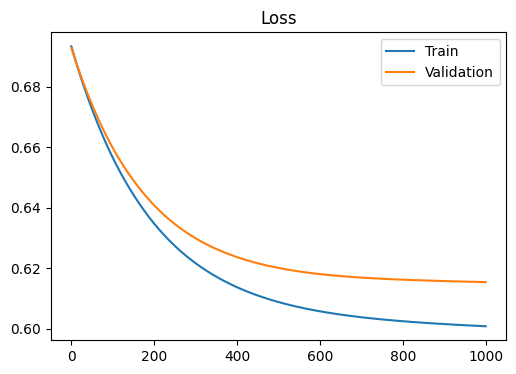

In [43]:
# Loss plot 
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()


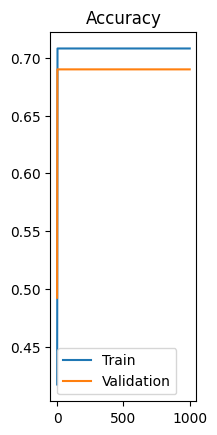

In [44]:
# Accuracy plot
plt.subplot(1,3,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()


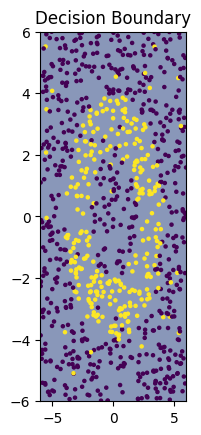

In [45]:
xx, yy = np.meshgrid(np.linspace(-6,6,300), np.linspace(-6,6,300))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    zz = forward(grid).reshape(xx.shape)

plt.subplot(1,3,3)
plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.6)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val.squeeze(), s=5)
plt.title("Decision Boundary")
plt.show()


#### Conclusion

The neural network successfully learns a complex non-linear geometry
despite noisy labels and strict implementation constraints.
